In [1]:
import time
import numpy as np
import pandas as pd

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt

from pathlib import Path

### Import data

In [2]:
df_Ch001 = pd.DataFrame(pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch001.pkl")))
df_Ch009 = pd.DataFrame(pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch009.pkl")))
df_Ch020 = pd.DataFrame(pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch020.pkl")))
df_Ch022 = pd.DataFrame(pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch022.pkl")))

### choosing L

In [3]:
p=34

### scaling data

In [4]:
from model_util import data_scale
from sklearn.preprocessing import MinMaxScaler, StandardScaler

df_input=[df_Ch001, df_Ch009, df_Ch020]
df_input_scaled=[]

LOG_SCALE= False
scaler=MinMaxScaler()

for df in df_input:
    df_input_scaled.append(data_scale(df, scaler, LOG_SCALE))

df_output_scaled, output_scaler = data_scale(df_Ch022, scaler, LOG_SCALE, output= True)

### formating and spliting data

In [5]:
from sklearn.model_selection import train_test_split

data=np.dstack(df_input_scaled)[:,:,:]
target=df_output_scaled.iloc[:,:].copy().values

size=len(df_Ch022.index)
split=int(size*0.15)

X_test=data[:split]
y_test=target[:split]

X_train=data[split:]
y_train=target[split:]

print(X_train.shape, X_test.shape, y_train.shape)

(4014, 3) (708, 3) (4014,)


### grid search and learning curve

In [6]:
svr_grid = GridSearchCV(SVR(kernel='rbf', gamma=0.1),
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

svr_grid.fit(X_train, y_train)

print(svr_grid.best_params_)

{'C': 100.0, 'gamma': 100.0}


In [7]:
C = svr_grid.best_params_['C']
gamma= svr_grid.best_params_['gamma']

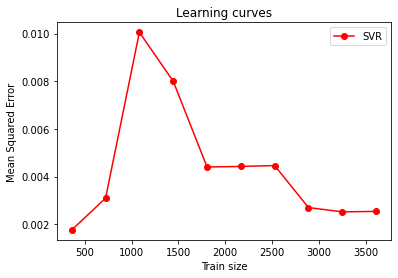

In [8]:
# Visualize learning curves
plt.figure()

svr_lc = SVR(kernel='rbf', C=C, gamma=gamma)
train_sizes, train_scores_svr, test_scores_svr = \
    learning_curve(svr_lc, X_train, y_train, train_sizes=np.linspace(0.1, 1, 10),
                   scoring="neg_mean_squared_error", cv=10)

plt.plot(train_sizes, -test_scores_svr.mean(1), 'o-', color="r", label="SVR")

plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title('Learning curves')
plt.legend(loc="best")

plt.show()

In [9]:
split = train_sizes[np.argmin(-test_scores_svr.mean(1))]
if split >int(size*0.5):
    X_test=data[:size-split]
    y_test=target[:size-split]

    X_train=data[size-split:]
    y_train=target[size-split:]

### mean square error

In [10]:
from sklearn.metrics import mean_squared_error

svr=SVR(kernel='rbf', C=C, gamma=gamma)
svr.fit(X_train, y_train)
y_pred_test = svr.predict(X_test)
print(mean_squared_error(y_test,y_pred_test))

0.0014016878121045618


### plot

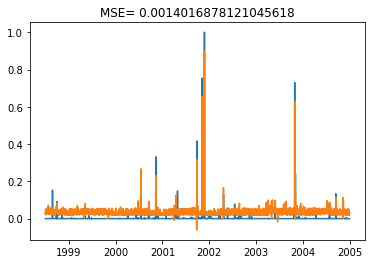

In [11]:
y_pred=svr.predict(data)

plt.figure()
plt.plot(df_Ch022.index, target)
plt.plot(df_Ch022.index, y_pred)
plt.title("MSE= " +str(mean_squared_error(y_test,y_pred_test)))
plt.show()
